In [3]:
import pandas as pd
X = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'], 
                  'boolean':['yes', 'no', None, 'no', 'no', 'yes'], 
                  'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'], 
                  'quantitative_column':[1, 11, -.5, 10, None, 20]})
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


- boolean: 是二元分类数据(是/否)，定类等级
- city: 此列是分类数据，也是定类等级
- ordinal_column: 顺序数据，定序等级
- quantitative_column: 整数，定比等级

In [5]:
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

In [7]:
X['city'].value_counts().index[0]

'tokyo'

In [6]:
X['city'].fillna(X['city'].value_counts().index[0])  # fill empty slots with most common category

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

In [8]:
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols=cols
    
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [9]:
cci = CustomCategoryImputer(cols=['city', 'boolean'])
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [24]:
from sklearn.preprocessing import Imputer

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols=cols
        self.strategy = strategy
        
    def transform(self, df):
        df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[col].values.reshape(-1, 1))
        return X
    
    def fit(self, *_):
        return self

In [25]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

In [26]:
from sklearn.pipeline import Pipeline

imputer = Pipeline([('quant', cqi), ('category', cci)])
imputer.fit_transform(X)

/Users/super/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [28]:
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [29]:
cd = CustomDummifier(cols=['boolean', 'city'])

cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,8.3,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


In [31]:
ordering = ['dislike', 'somewhat like', 'like']  # 0 for dislike, 1 for somewhat like, and 2 for like

X['ordinal_column']

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object

In [32]:
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

In [33]:
ce = CustomEncoder(col='ordinal_column', ordering = ['dislike', 'somewhat like', 'like'])

ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,None,no,2,11.0
2,london,None,1,-0.5
3,seattle,no,2,10.0
4,san francisco,no,1,8.3
5,tokyo,yes,0,20.0


In [34]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [35]:
cc = CustomCutter(col='quantitative_column', bins=3)

cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0
1,None,no,like,1
2,london,None,somewhat like,0
3,seattle,no,like,1
4,san francisco,no,somewhat like,1
5,tokyo,yes,dislike,2


# 4. 拓展数值特征

In [37]:
df = pd.read_csv('~/开发/AI相关/特征工程/Feature-Engineering-Made-Easy-master/data/activity_recognizer/1.csv')

In [38]:
df.head()

,0,1502,2215,2153,1
0,1.0,1667,2072,2047,1
1,2.0,1611,1957,1906,1
2,3.0,1601,1939,1831,1
3,4.0,1643,1965,1879,1
4,5.0,1604,1959,1921,1


In [39]:
df.columns = ['index', 'x', 'y', 'z', 'activity']
df.head()

,index,x,y,z,activity
0,1.0,1667,2072,2047,1
1,2.0,1611,1957,1906,1
2,3.0,1601,1939,1831,1
3,4.0,1643,1965,1879,1
4,5.0,1604,1959,1921,1


In [40]:
df['x'].mean()

1910.6733723076923

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x', 'y', 'z']]
y = df['activity']

knn_params = {'n_neighbors':[3,4,5,6]}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

/Users/super/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/super/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.7205230769230769 {'n_neighbors': 5}


In [42]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only = False)
X_poly = poly.fit_transform(X)
X_poly.shape

(162500, 9)

In [43]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
1,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
2,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
3,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0
4,1604.0,1959.0,1921.0,2572816.0,3142236.0,3081284.0,3837681.0,3763239.0,3690241.0


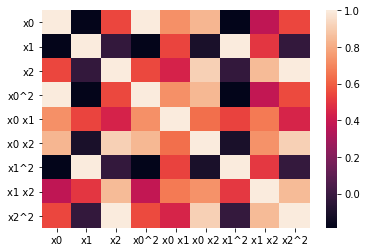

In [45]:
%matplotlib inline
import seaborn as sns
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [47]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X_poly = poly.fit_transform(X)
print(X_poly.shape)

pd.DataFrame(X_poly, columns=poly.get_feature_names()).head() 

(162500, 6)


,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
1,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
2,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
3,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0
4,1604.0,1959.0,1921.0,3142236.0,3081284.0,3763239.0


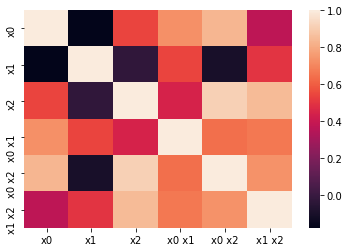

In [48]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [50]:
pipe_params = {'poly_features__degree':[1, 2, 3], 'poly_features__interaction_only':[True, False], 'classify__n_neighbors':[3, 4, 5, 6]}

pipe = Pipeline([('poly_features', poly), ('classify', knn)])

grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

/Users/super/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/super/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.7207323076923077 {'classify__n_neighbors': 5, 'poly_features__degree': 3, 'poly_features__interaction_only': False}
